In [1]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd 
import random, os
import torch
from torch import nn

In [2]:
FEATURE_ARR = [16,32,64,128] # [64,128,256,512]

# for loading encoder and decoder:
LOAD_PATH_ENC = "checkpoints/encoder/"          # path to where encoder is
ENC_NAME = "epoch-499"              # name of saved encoder

LOAD_PATH_DEC = "checkpoints/decoder/"            # path to where decoder is
DEC_NAME = "epoch-499"            # name of saved decoder

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class Encoder(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, FEATURE_ARR[0], 5, stride=2, padding=1),
            nn.BatchNorm2d(FEATURE_ARR[0]),
            nn.ReLU(True),
            nn.Conv2d(FEATURE_ARR[0], FEATURE_ARR[1], 5, stride=2, padding=1),
            nn.BatchNorm2d(FEATURE_ARR[1]),
            nn.ReLU(True),
            nn.Conv2d(FEATURE_ARR[1], FEATURE_ARR[2], 5, stride=2, padding=1),
            nn.BatchNorm2d(FEATURE_ARR[2]),
            nn.ReLU(True),     
            nn.Conv2d(FEATURE_ARR[2], FEATURE_ARR[3], 7, stride=2, padding=0),
            nn.BatchNorm2d(FEATURE_ARR[3]),
            nn.ReLU(True),  
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        return x

In [4]:
class Decoder(nn.Module):
    
    def __init__(self):
        super().__init__()

        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(FEATURE_ARR[3], 1, 1))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(FEATURE_ARR[3], FEATURE_ARR[2], 7, 
            stride=2, padding=0, output_padding=0),
            nn.BatchNorm2d(FEATURE_ARR[2]),
            nn.ReLU(True),
            nn.ConvTranspose2d(FEATURE_ARR[2], FEATURE_ARR[1], 5, 
            stride=2, padding=1, output_padding=0),
            nn.BatchNorm2d(FEATURE_ARR[1]),
            nn.ReLU(True),
            nn.ConvTranspose2d(FEATURE_ARR[1], FEATURE_ARR[0], 5, 
            stride=2, padding=1, output_padding=0),
            nn.BatchNorm2d(FEATURE_ARR[0]),
            nn.ReLU(True),
            nn.ConvTranspose2d(FEATURE_ARR[0], 1, 5, 
            stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [5]:
encoder = Encoder()
decoder = Decoder()

In [6]:
# LOAD ENCODER:
checkpoint = torch.load(f'{LOAD_PATH_ENC}{ENC_NAME}.tar')
encoder.load_state_dict(checkpoint['model_state_dict'])
encoder.to(device)
encoder.eval()

# LOAD LSTM:
checkpoint = torch.load(f'{LOAD_PATH_DEC}{DEC_NAME}.tar')
decoder.load_state_dict(checkpoint['model_state_dict'])
decoder.to(device)
decoder.eval()

Decoder(
  (unflatten): Unflatten(dim=1, unflattened_size=(128, 1, 1))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(7, 7), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(32, 16, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(16, 1, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

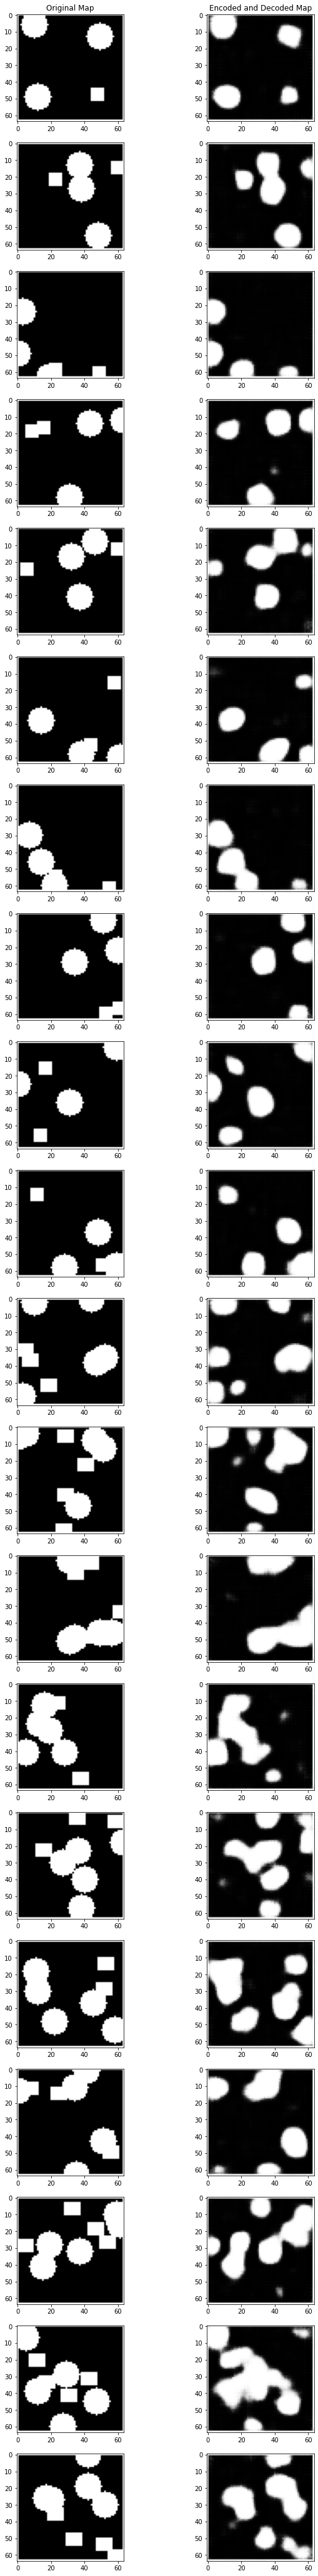

In [12]:
# example using encoder/decoder on loaded map
NUM_MAPS = 20
DIR_NAME = "env/random_multi_density/eval/"

# setting up figure:
fig = plt.figure(figsize=(10,75))
fig.set_facecolor('white')

plot_num = 1
for i in range(NUM_MAPS):

    # loading map:
    flat_map = np.loadtxt(f"{DIR_NAME}map_{i}/map_{i}.txt") 
    map = torch.tensor(np.asarray(flat_map, dtype=int).reshape(64, 64)).to(device, dtype=torch.float)     # unflatten the map from the file

    # encoding and decoding map:
    map_4d = map.unsqueeze(0).unsqueeze(0)
    encoded_map = encoder(map_4d)
    decoded_map = decoder(encoded_map)
    new_map_2d = decoded_map.squeeze()

    # plot og map:
    sub = fig.add_subplot(NUM_MAPS,2,plot_num)
    plt.imshow(map.cpu(), cmap='gray')
    if plot_num < 3:
        plt.title('Original Map')
    plot_num += 1

    # plot encoded and decoded map:
    sub = fig.add_subplot(NUM_MAPS,2,plot_num)
    plt.imshow(new_map_2d.cpu().detach().numpy(), cmap='gray')
    if plot_num < 3:
        plt.title('Encoded and Decoded Map')
    plot_num += 1

plt.show()

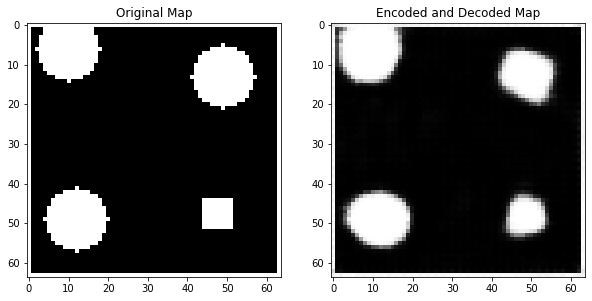

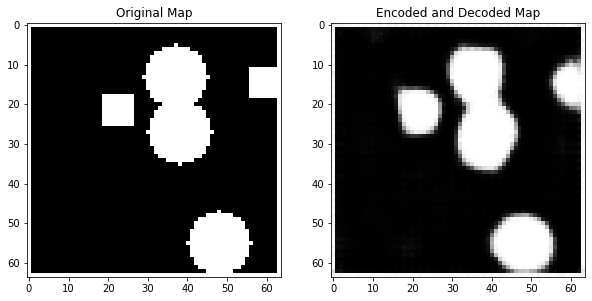

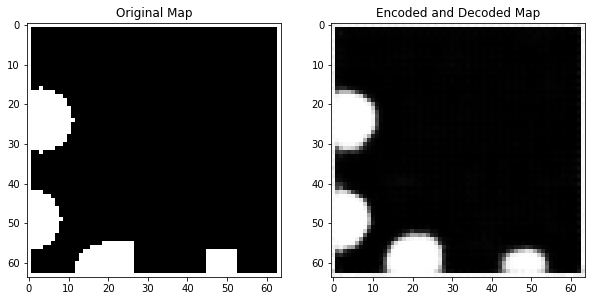

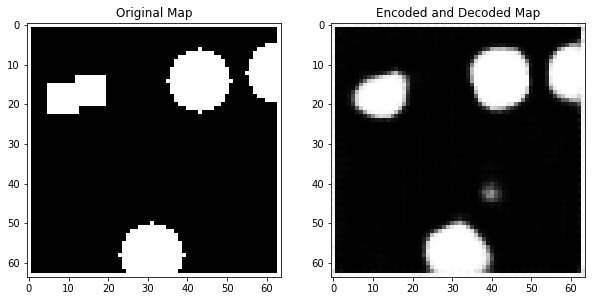

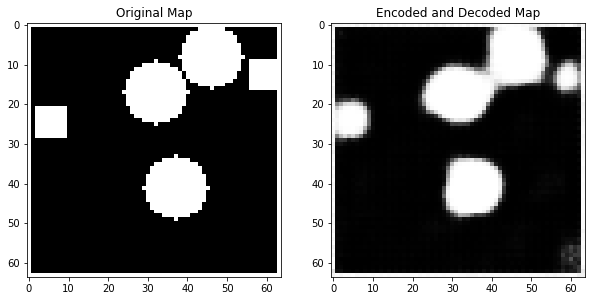

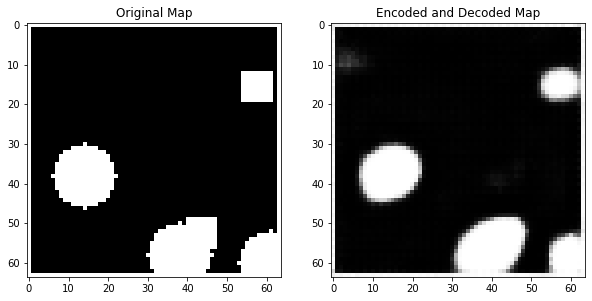

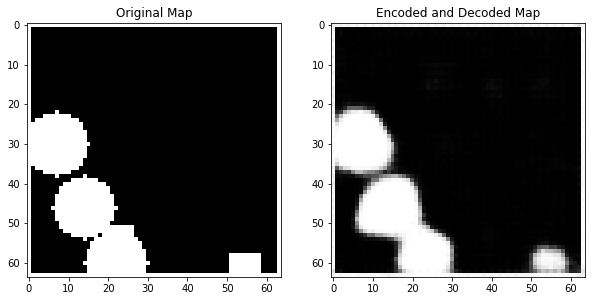

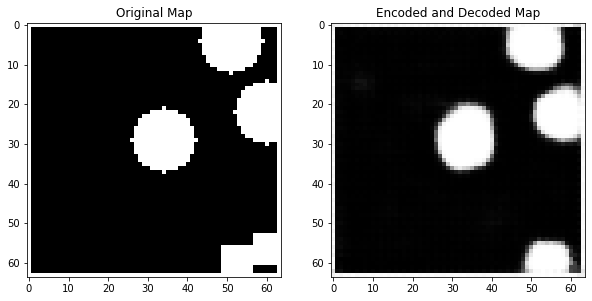

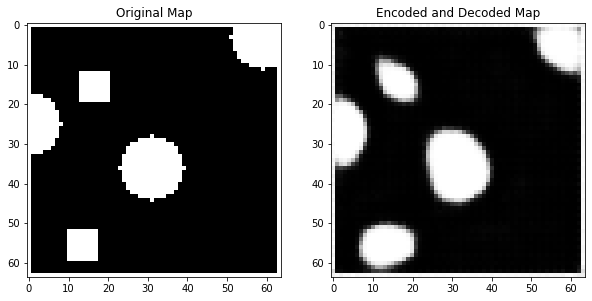

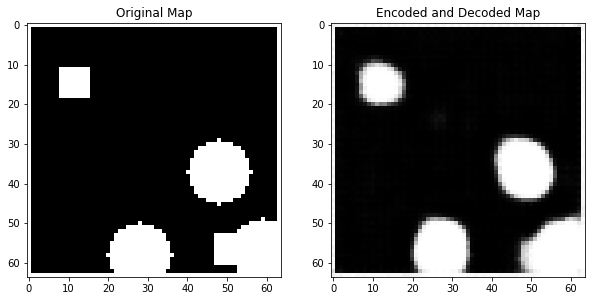

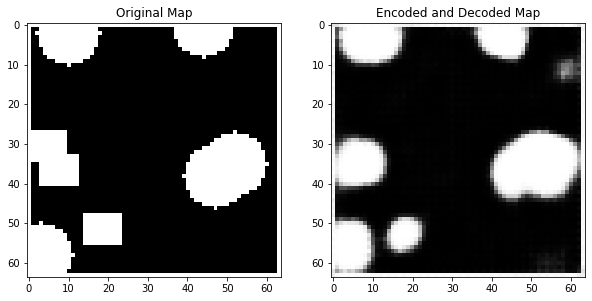

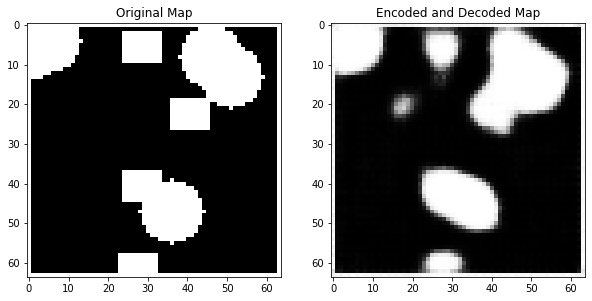

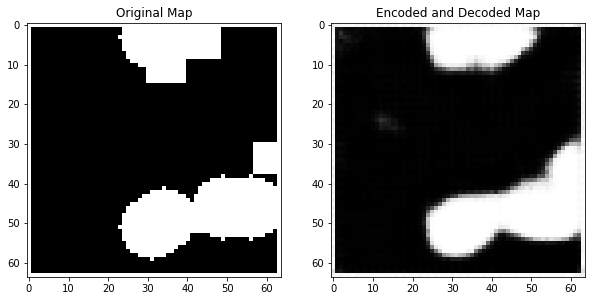

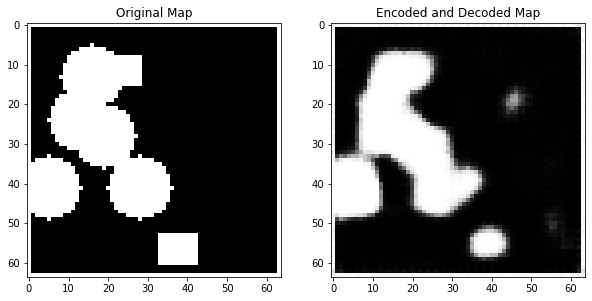

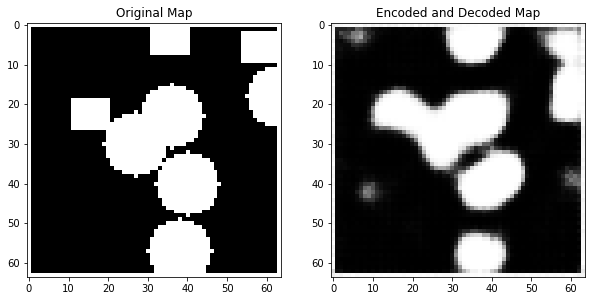

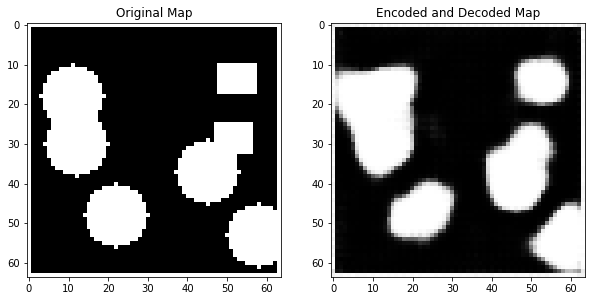

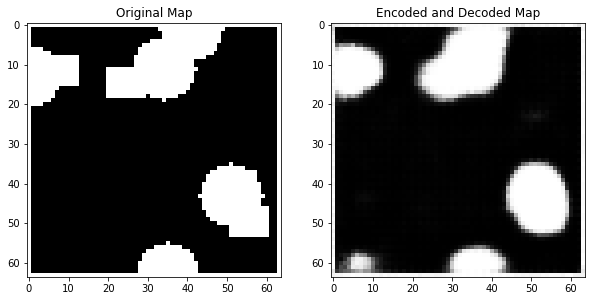

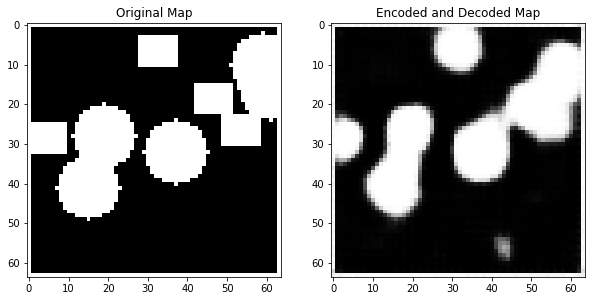

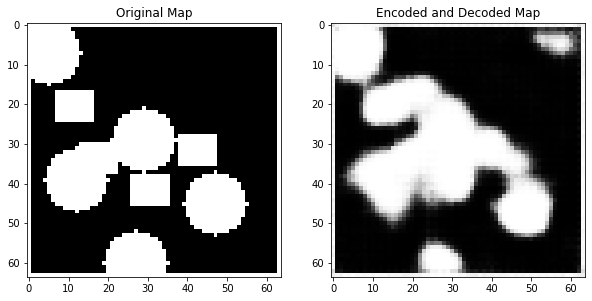

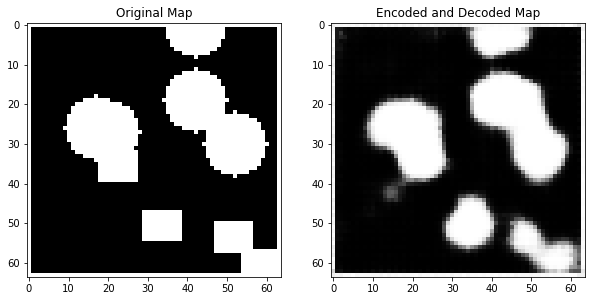

In [14]:
for i in range(NUM_MAPS):

    # loading map:
    flat_map = np.loadtxt(f"{DIR_NAME}map_{i}/map_{i}.txt") 
    map = torch.tensor(np.asarray(flat_map, dtype=int).reshape(64, 64)).to(device, dtype=torch.float)     # unflatten the map from the file

    # encoding and decoding map:
    map_4d = map.unsqueeze(0).unsqueeze(0)
    encoded_map = encoder(map_4d)
    decoded_map = decoder(encoded_map)
    new_map_2d = decoded_map.squeeze()

    # setting up figure:
    fig = plt.figure(figsize=(10,25))
    fig.set_facecolor('white')

    # plot og map:
    sub = fig.add_subplot(121)
    plt.imshow(map.cpu(), cmap='gray')
    plt.title('Original Map')

    # plot encoded and decoded map:
    sub = fig.add_subplot(122)
    plt.imshow(new_map_2d.cpu().detach().numpy(), cmap='gray')
    plt.title('Encoded and Decoded Map')

    plt.savefig(f"outputs/map_{i}.png", facecolor=fig.get_facecolor(), bbox_inches='tight')
    plt.show()